# POC: CPU Inference on Test Tiles (No Tiling)

This notebook is a minimal, readable proof-of-concept to run one ONNX inference pass on the local test tile pair.

 
## Scope
- CPU only (`CPUExecutionProvider`)
- No tiling/windowing, no batching beyond `batch=1`
- Keep the notebook skinny and explicit
        


## 1) Setup and Paths
        


In [ ]:
# Major imports for this notebook.
from pathlib import Path
import importlib.metadata as md

import numpy as np
import onnx
import rasterio
import matplotlib.pyplot as plt




Using files:
  model: /workspace/_inputs/4690176_0_1770580046_train_base_16/model_infer.onnx
  depth: /workspace/tests/data/2407_FHIMP_tile/depths.tif
  dem:   /workspace/tests/data/2407_FHIMP_tile/dem.tif


In [8]:

# Keep all paths explicit for readability.
ROOT = Path("/workspace")
MODEL_FP = ROOT / "_inputs/4690176_0_1770580046_train_base_16/model_infer.onnx"
TILE_DIR = ROOT / "tests/data/2407_FHIMP_tile"
DEPTH_FP = TILE_DIR / "depths.tif"
DEM_FP = TILE_DIR / "dem.tif"
OUT_FP = ROOT / "dev/poc_depth_hr_pred.tif"

# Assert the key files exist before doing work.
assert MODEL_FP.exists(), f"missing model file: {MODEL_FP}"
assert DEPTH_FP.exists(), f"missing depth tile: {DEPTH_FP}"
assert DEM_FP.exists(), f"missing dem tile: {DEM_FP}"

print("Using files:")
print(f"  model: {MODEL_FP}")
print(f"  depth: {DEPTH_FP}")
print(f"  dem:   {DEM_FP}")
        


Using files:
  model: /workspace/_inputs/4690176_0_1770580046_train_base_16/model_infer.onnx
  depth: /workspace/tests/data/2407_FHIMP_tile/depths.tif
  dem:   /workspace/tests/data/2407_FHIMP_tile/dem.tif


## 2) Environment Probe (Package Versions)

This keeps API/debug context tied to the current environment.
        


In [2]:
# Report versions of the core packages used in this notebook.
for pkg_name in ["numpy", "rasterio", "onnx", "onnxruntime"]:
    try:
        print(f"{pkg_name}: {md.version(pkg_name)}")
    except md.PackageNotFoundError:
        print(f"{pkg_name}: MISSING (install in this environment)")
        


numpy: 2.4.2
rasterio: 1.5.0
onnx: 1.18.0
onnxruntime: 1.24.1


## 3) Probe the ONNX Weights File

This cell inspects graph metadata, opset, and I/O tensor shapes.
        


In [3]:
# Load the model and print a compact summary of the graph contract.
onnx_model = onnx.load(MODEL_FP.as_posix())
print(f"model size (MB): {MODEL_FP.stat().st_size / 1e6:.2f}")
print(f"producer: {onnx_model.producer_name} {onnx_model.producer_version}")
print(f"IR version: {onnx_model.ir_version}")
print("opsets:")
for opset in onnx_model.opset_import:
    domain = opset.domain if opset.domain else "ai.onnx"
    print(f"  - {domain}: {opset.version}")

print()
print("inputs:")
for tensor in onnx_model.graph.input:
    t = tensor.type.tensor_type
    dims = []
    for dim in t.shape.dim:
        if dim.dim_param:
            dims.append(dim.dim_param)
        elif dim.dim_value:
            dims.append(dim.dim_value)
        else:
            dims.append("?")
    print(f"  - {tensor.name}: dtype={t.elem_type}, shape={dims}")

print()
print("outputs:")
for tensor in onnx_model.graph.output:
    t = tensor.type.tensor_type
    dims = []
    for dim in t.shape.dim:
        if dim.dim_param:
            dims.append(dim.dim_param)
        elif dim.dim_value:
            dims.append(dim.dim_value)
        else:
            dims.append("?")
    print(f"  - {tensor.name}: dtype={t.elem_type}, shape={dims}")
        


model size (MB): 24.11
producer: tf2onnx 1.8.4
IR version: 7
opsets:
  - ai.onnx: 13

inputs:
  - depth_lr: dtype=1, shape=['unk__300', 32, 32, 1]
  - dem_hr: dtype=1, shape=['unk__301', 512, 512, 1]

outputs:
  - depth_hr_pred: dtype=1, shape=['unk__302', 512, 512, 1]


## 4) Load Test Tiles (Single Pair)

No windowing or tiling logic is used here; each raster is read once in full.
        


In [4]:
# Read depth LR tile and keep metadata useful for diagnostics.
with rasterio.open(DEPTH_FP) as ds:
    depth_lr = ds.read(1).astype(np.float32)
    depth_nodata = ds.nodata
    depth_profile = ds.profile.copy()

# Read DEM HR tile and keep metadata useful for output writing.
with rasterio.open(DEM_FP) as ds:
    dem_hr = ds.read(1).astype(np.float32)
    dem_nodata = ds.nodata
    dem_profile = ds.profile.copy()

print(f"depth_lr shape={depth_lr.shape}, dtype={depth_lr.dtype}, nodata={depth_nodata}")
print(f"dem_hr   shape={dem_hr.shape}, dtype={dem_hr.dtype}, nodata={dem_nodata}")

# Replace nodata with 0.0 for this lightweight proof-of-concept.
if depth_nodata is not None:
    depth_lr = np.where(np.isclose(depth_lr, depth_nodata), 0.0, depth_lr)
if dem_nodata is not None:
    dem_hr = np.where(np.isclose(dem_hr, dem_nodata), 0.0, dem_hr)

print(f"depth_lr min={depth_lr.min():.4f}, max={depth_lr.max():.4f}")
print(f"dem_hr   min={dem_hr.min():.4f}, max={dem_hr.max():.4f}")
        


depth_lr shape=(32, 32), dtype=float32, nodata=-9999.0
dem_hr   shape=(512, 512), dtype=float32, nodata=-9999.0
depth_lr min=0.0000, max=2.5960
dem_hr   min=1073.6890, max=1092.5730


## 5) Run ONNX Runtime Inference (CPU Only)

The session is pinned to `CPUExecutionProvider` by design.
        


In [9]:
import onnxruntime as ort

In [ ]:
# Import ORT lazily so missing dependency errors are clear and local.
 

# Confirm available providers, then force CPU-only inference.
available_providers = ort.get_available_providers()
print(f"available providers: {available_providers}")
assert "CPUExecutionProvider" in available_providers, "CPUExecutionProvider is unavailable"

session = ort.InferenceSession(
    MODEL_FP.as_posix(),
    providers=["CPUExecutionProvider"],
)

# Probe model I/O names directly from the loaded session.
session_input_names = [x.name for x in session.get_inputs()]
session_output_names = [x.name for x in session.get_outputs()]
print(f"session inputs:  {session_input_names}")
print(f"session outputs: {session_output_names}")

# Convert rasters to NHWC with batch dimension expected by this model.
depth_lr_nhwc = depth_lr[np.newaxis, :, :, np.newaxis].astype(np.float32)
dem_hr_nhwc = dem_hr[np.newaxis, :, :, np.newaxis].astype(np.float32)

# Keep assertions short and explicit near the data handoff boundary.
assert depth_lr_nhwc.shape == (1, 32, 32, 1), f"unexpected depth shape: {depth_lr_nhwc.shape}"
assert dem_hr_nhwc.shape == (1, 512, 512, 1), f"unexpected dem shape: {dem_hr_nhwc.shape}"

# Build the feed dict by input name to avoid ordering assumptions.
feed_dict = {}
for input_name in session_input_names:
    if input_name == "depth_lr":
        feed_dict[input_name] = depth_lr_nhwc
    elif input_name == "dem_hr":
        feed_dict[input_name] = dem_hr_nhwc

assert "depth_lr" in feed_dict, "missing depth_lr input for model"
assert "dem_hr" in feed_dict, "missing dem_hr input for model"

# Run one forward pass and strip batch/channel dimensions for display/export.
outputs = session.run(session_output_names, feed_dict)
depth_hr_pred = outputs[0][0, :, :, 0].astype(np.float32)

print(f"prediction shape={depth_hr_pred.shape}, dtype={depth_hr_pred.dtype}")
print(f"prediction min={depth_hr_pred.min():.4f}, max={depth_hr_pred.max():.4f}")
print(f"prediction mean={depth_hr_pred.mean():.4f}, std={depth_hr_pred.std():.4f}")
        


available providers: ['AzureExecutionProvider', 'CPUExecutionProvider']
session inputs:  ['depth_lr', 'dem_hr']
session outputs: ['depth_hr_pred']
prediction shape=(512, 512), dtype=float32
prediction min=-18.5848, max=59.7029
prediction mean=-3.3970, std=1.6415


## 6) Quick Visual Check

Simple side-by-side display for proof-of-concept diagnostics.
        


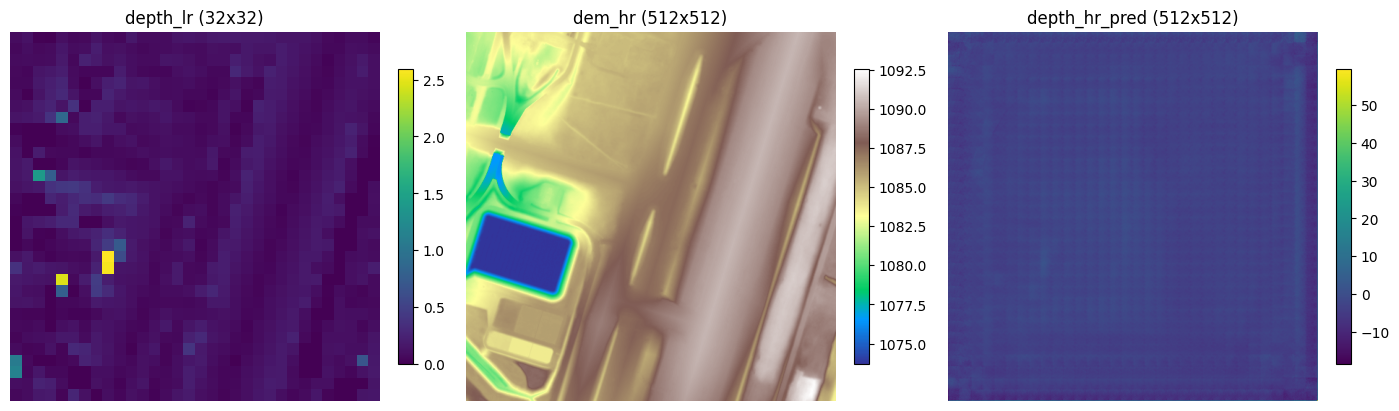

In [6]:
# Plot the low-res depth, high-res DEM, and predicted high-res depth.
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

im0 = axes[0].imshow(depth_lr, cmap="viridis")
axes[0].set_title("depth_lr (32x32)")
axes[0].set_axis_off()
fig.colorbar(im0, ax=axes[0], shrink=0.8)

im1 = axes[1].imshow(dem_hr, cmap="terrain")
axes[1].set_title("dem_hr (512x512)")
axes[1].set_axis_off()
fig.colorbar(im1, ax=axes[1], shrink=0.8)

im2 = axes[2].imshow(depth_hr_pred, cmap="viridis")
axes[2].set_title("depth_hr_pred (512x512)")
axes[2].set_axis_off()
fig.colorbar(im2, ax=axes[2], shrink=0.8)

plt.show()
        
